# The network:
1. CNN character level word embedder
1. concatenate CNN embedding with word embedding
1. bi-directional LSTM block, looking at a sentence
1. fully conncected layer? (what does linear projection mean?)

In [2]:
# !pip install fastprogress matplotlib
import os
import math
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from fastprogress import progress_bar, master_bar
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

KAGGLE = True

training_data = Path("../input/sents.train") if KAGGLE else Path("../data/sents.train")

# Creating data input pipeline

In [13]:
import torch
import torch.utils.data
from random import uniform


class Dataset(torch.utils.data.Dataset):
    def __init__(self, path, to_lower=True, training=True, make_unknown=None, letter_emb_len=15, too_long_split=10):
        self.to_lower = to_lower
        self.training = training
        self.make_unknown = make_unknown
        self.letter_emb_len = letter_emb_len
        self.too_long_split = too_long_split
        
        self.sentences = []
        self.vocab = []
        self.tags = []
        
        self.generate_dataset(path)
        self.UNKONWN_WORD = len(self.vocab) + 1
        
        self.LETTER_MIN = 32
        self.LETTER_MAX = 126
        self.letter_len = self.LETTER_MAX - self.LETTER_MIN + 2
        self.UNKNOWN_LETTER = self.letter_len

    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, index):
        sentence_embs, tag_embs = self.transform_sentence(self.sentences[index])
        return sentence_embs, tag_embs
    
    def generate_dataset(self, path):
        with open(path, 'r') as input_file:
            self.sentences = input_file.read().split("\n")
            
            if len(self.vocab) == 0:
                self.create_vocabs(self.sentences)
                self.vocab_size = len(self.vocab) + 2 # Unkown words, padding
                self.tag_size = len(self.tags) + 1 # Padding
            
            if self.sentences[-1] == "":
                self.sentences.pop()
    
    def create_vocabs(self, sentences):
        vocab_set = set()
        tag_set = set()

        for sentence in sentences:
            for word in sentence.split(" "):
                try:
                    word, tag = self.split_words_tag(word)
                    vocab_set.add(word.lower() if self.to_lower else word)
                    tag_set.add(tag)
                except RuntimeError:
                    print("Not a valid word/tag pair: " + word)

        self.vocab = list(vocab_set)
        self.tags = list(tag_set)
            
    def transform_sentence(self, sentence):
        numeric_sent, letter_embs, tags = [], [], []

        for word_tag in sentence.split(" "):
            try:
                if self.training:
                    word, tag = self.split_words_tag(word_tag)
                    tag_id = self.tags.index(tag) + 1
                    word_id = self.get_word_id(word)                    
                else:
                    word = word_tag
                    word_id = self.vocab.index(word.lower() if self.to_lower else word) + 1

            except RuntimeError:
                print("Not a valid word/tag pair: " + word_tag)
            except ValueError:
#                 print("Word not in the vocab: " + word_tag)
                # The id of an unknown word
                word_id = self.UNKONWN_WORD

            numeric_sent.append(word_id)
            letter_embs.append(self.transform_word(word))
            if self.training: tags.append(tag_id)

        return (torch.tensor(numeric_sent), torch.cat(letter_embs).view(-1, self.letter_emb_len)), torch.tensor(tags) if self.training else []
    
    def get_word_id(self, word):
        # Replacing a random subset of words with the unkown word id
        if self.make_unknown is not None:
            if uniform(0, 1) < self.make_unknown:
                return self.UNKONWN_WORD
            else:
                return self.vocab.index(word.lower() if self.to_lower else word) + 1
        else:
            return self.vocab.index(word.lower() if self.to_lower else word) + 1
        
    def transform_word(self, word):
        # 32 -> 126 range
        word_len = len(word)
        letter_embs = torch.zeros(self.letter_emb_len, dtype=torch.int64)
        
        if word_len <= self.letter_emb_len:
            for i, letter in enumerate(word):
                emb = ord(letter)
                letter_embs[i] = emb - self.LETTER_MIN + 1 if(emb >= self.LETTER_MIN <= self.LETTER_MAX) else self.UNKNOWN_LETTER
        else:
            #Word is too long for embedding
            for i in range(self.letter_emb_len):
                if i <= self.too_long_split:
                    letter_embs[i] = ord(word[i]) - self.LETTER_MIN
                else:
                    letter_embs[i] = ord(word[-(self.letter_emb_len - i)]) - self.LETTER_MIN
                    
        return letter_embs

    @staticmethod
    def split_words_tag(word):
        words_tag = word.split("/")
        
        if len(words_tag) < 2: 
            raise RuntimeError("Not a valid word/tag pair:" + word)
            
        tag = words_tag.pop()
        word = "/".join(words_tag)
        
        return word, tag
    
    def print_sentence(self, sentence):
        print(" ".join([self.vocab[word.item()] for word in sentence.view(-1)]))
                
    def decode_sentence(self, sentence):
        print(sentence)
        answ = [self.vocab[word.item() - 1] for word in sentence.view(-1)]
        return answ
    
    def decode_tags(self, tag_ids):
        return [self.tags[tag.item() - 1] for tag in tag_ids.view(-1)]
    
    def __getstate__(self):
        d = dict(self.__dict__)
        del d['sentences']
        return d
    
    def __setstate(self, d):
        self.__dict__.update(d)
        self.__dict__.update({'sentences': []})

## Pad the input so that it is possible to use mini-batches

- Padding | https://discuss.pytorch.org/t/understanding-pack-padded-sequence-and-pad-packed-sequence/4099
- Padding | https://discuss.pytorch.org/t/simple-working-example-how-to-use-packing-for-variable-length-sequence-inputs-for-rnn/2120

## The padding needs to take place in the DataLoader
- Most likely will need to use sampler & collate_fn


In [4]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def pad_seq(sequences):
    x_word, x_let, y = [], [], []
    
    for (word_embs, letter_embs), targets in sequences:
        x_word.append(word_embs)
        x_let.append(letter_embs)
        y.append(targets)
        
    return (pad_sequence(x_word, batch_first=True), pad_sequence(x_let, batch_first=True)) , pad_sequence(y, batch_first=True)

# Initial simple model implementation 

## Proposed plan:
1. Begin with word-level LSTM (check for an example in forum)
2. Make it bi-directional
3. Add character-level CNN

Try a new notebook: https://polynote.org/docs/01-installation.html

In [36]:
class LstmCnnTagger(nn.Module):
    def __init__(self, word_emb_dim, letter_emb_dim, hidden_dim, word_vocab_size, letter_vocab_size, letter_word_size, tagset_size):
        super(LstmCnnTagger, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.letter_word_size = letter_word_size # 15
        self.letter_emb_dim = letter_emb_dim
        self.word_emb_dim = word_emb_dim

        self.word_embeddings = nn.Embedding(word_vocab_size, word_emb_dim)
        self.letter_embeddings = nn.Embedding(letter_vocab_size, letter_emb_dim)
        
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=23, kernel_size=5)
        self.max_pool = nn.MaxPool2d(2,2)
        self.cnn2 = nn.Conv2d(in_channels=23, out_channels=word_emb_dim, kernel_size=3)
        self.max_pool_last = nn.MaxPool2d(2, 10)

        self.lstm = nn.LSTM(word_emb_dim * 2, hidden_dim)        
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
    
    def forward(self, sentence):
        words, letters = sentence
        batches = words.shape[0]
        
        word_embeds = self.word_embeddings(words)
        letter_embeds = self.letter_embeddings(letters.view(-1, self.letter_word_size))

        cnn_feat = self.cnn1(letter_embeds.view(-1, 1, self.letter_word_size, self.letter_emb_dim))
        cnn_feat = F.relu(self.max_pool(cnn_feat))
        cnn_feat = self.cnn2(cnn_feat)
        cnn_feat = F.relu(self.max_pool_last(cnn_feat))
            
        concat = torch.cat([
            cnn_feat.view(len(words[-1]), batches, self.word_emb_dim), 
            word_embeds.view(len(words[-1]), batches, -1)
        ], 2)
        
        lstm_out, _ = self.lstm(concat)
        tag_space = self.hidden2tag(lstm_out.view(len(words[-1]) * batches, -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        
        return tag_scores

In [29]:
def train_model(model, data_loader, epochs=1, lr=0.01, patience=10, lr_decrease=2):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    print("Device: {}". format(device))

    loss_func = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    tagset_size = data_loader.dataset.tag_size
    losses = []
    i = 0
    
    last_min_loss = 10
    steps_after_loss = 0

    model.to(device)
    model.zero_grad()

    master = master_bar(range(epochs))
    for epoch in master:
        for (x1, x2), y in progress_bar(data_loader, parent=master):

            model.zero_grad()
            x, y = (x1.to(device), x2.to(device)), y.to(device)

            pred = model(x)
            loss = loss_func(pred.view(-1, tagset_size), y.view(-1))

            loss.backward()
            optimizer.step()
            
            if loss.item() < last_min_loss:
                last_min_loss = loss.item()
                steps_after_loss = 0
            elif steps_after_loss > patience:
                steps_after_loss = 0
                lr = lr / lr_decrease
                optimizer = optim.Adam(model.parameters(), lr=lr)
                print("No decrease in loss for " + str(patience) + " steps. Decrementing lr: " + str(lr))
            else:
                steps_after_loss += 1

            if i % 10 == 0: 
                losses.append(loss.item())
                print("Loss: " + str(loss.item()))
            i += 1
            
    plt.plot(losses)
    print("Min loss: " + str(min(losses)))

In [7]:
def export_model(model, dataset, train_time):
    model_name = str(type(model)).split(".")[-1][:-2]
    model_save_name = model_name + "_" + str(train_time)
    
    torch.save(model, model_save_name + "_1.data")
    torch.save(dataset, model_save_name + "_2.data")

In [8]:
from torch.utils.data import DataLoader

def prepare_dataset_infer(dataset, input_filename):
    dataset.generate_dataset(input_filename)
    dataset.training = False
    return dataset

def generate_results(model, dataset, num_workers=0):
    cpu = torch.device("cpu")
    model.to(cpu)
    
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=num_workers)
    preds = []
    for i, (x, _) in enumerate(dataloader):
        if i % 100 == 0: 
            print("{} | {}".format(i, len(dataloader.dataset)))
            
        predictions = model(x)
        _, pos_tag_ids = predictions.max(1)

        words = dataset.sentences[i].split(" ")
        tags = dataset.decode_tags(pos_tag_ids)
        word_tags = ["/".join(word_tag) for word_tag in zip(words, tags)]

        preds.append(" ".join(word_tags))
    
    return preds
        
def export_preds(preds, filename):
    with open(filename, "w") as out_file:
        out_file.write("\n".join(preds))


# Execution

In [37]:
dataset = Dataset(training_data, make_unknown=0.05)

num_workers = 2

pos_dataloader = DataLoader(
    dataset, 
    batch_size=1, 
    num_workers=num_workers
)

pos_dataloader_batched = DataLoader(
    dataset,
    batch_size=128,
    collate_fn=pad_seq,
    num_workers=num_workers
)

Not a valid word/tag pair: 


In [38]:
model_cnn = LstmCnnTagger(
    word_emb_dim=256, 
    letter_emb_dim=30, 
    hidden_dim=256, 
    word_vocab_size=dataset.vocab_size, 
    letter_vocab_size=dataset.letter_len, 
    letter_word_size=dataset.letter_emb_len, 
    tagset_size=dataset.tag_size
)

Device: cuda


Loss: 3.8083395957946777
Loss: 0.6660836338996887
Loss: 0.7792799472808838
Loss: 0.49007388949394226
Loss: 0.5908881425857544
Loss: 0.44627466797828674
Loss: 0.34107425808906555
Loss: 0.33643025159835815
Loss: 0.2935137152671814
Loss: 0.21591617166996002
Loss: 0.2338472604751587
Loss: 0.20052789151668549
Loss: 0.13216207921504974
Loss: 0.17689625918865204
Loss: 0.18714061379432678
Loss: 0.10605884343385696
Loss: 0.13266204297542572
Loss: 0.11665935814380646
Loss: 0.13153597712516785
No decrease in loss for 50 steps. Decrementing lr: 0.005
Loss: 0.1524566411972046
Loss: 0.1322701871395111
Loss: 0.1067795529961586
Loss: 0.12890398502349854
Loss: 0.10315176844596863
Loss: 0.08411089330911636
No decrease in loss for 50 steps. Decrementing lr: 0.0025
Loss: 0.09963709861040115
Loss: 0.12511323392391205
Loss: 0.10418090224266052
Loss: 0.09216538071632385
Loss: 0.10344715416431427
Loss: 0.09092838317155838
Loss: 0.10053832083940506
Min loss: 0.08411089330911636


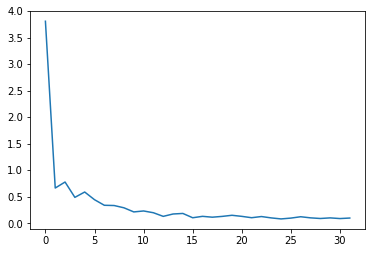

In [39]:
train_model(model_cnn, pos_dataloader_batched, epochs=2, lr=0.01, patience=70)

## Exporting trained model and built dictionary

In [ ]:
export_model(model, dataset, 5)

In [40]:
import copy
test_data = Path("../input/sents.test")

test_dataset = prepare_dataset_infer(copy.deepcopy(dataset), test_data)
predictions = generate_results(model_cnn, test_dataset, num_workers=2)
export_preds(predictions, "test_output.txt")
!python3 ../input/eval.py test_output.txt ../input/sents.answer

#Accuracy= 0.8980328763672244 - 2 epochs, lr: 0.01, unk: 0.01->0.50
#Accuracy= 0.9002792181890706 - 2 epochs, lr: 0.005, unk: 0.05
#Accuracy= 0.930237440429954  - epochs=1, lr=0.01, patience=50
#Accuracy= 0.9404614447966746 - epochs=5, unk=0.01

0 | 1993
100 | 1993
200 | 1993
300 | 1993
400 | 1993
500 | 1993
600 | 1993
700 | 1993
800 | 1993
900 | 1993
1000 | 1993
1100 | 1993
1200 | 1993
1300 | 1993
1400 | 1993
1500 | 1993
1600 | 1993
1700 | 1993
1800 | 1993
1900 | 1993
Accuracy= 0.930237440429954
